## CRISP-DM (https://www.datascience-pm.com/crisp-dm-2/)

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
- 4. Modeling
- 5. Evaluation
- 6. Deployment

### 1. Business Understanding - Jonnas

- 1.1. Determine business objectives
- 1.2. Assess situation
- 1.3. Determine data mining goals
- 1.4. Produce project plan

Isto deve ser so teorico

### 2. Data Understanding - Vicente

- 2.1. Collect initial data - ler os dados todos
- 2.2. Describe data - examinar os dados e descreve-los, as suas propriedades, numero de ocorrencia, etc.
- 2.3. Explore data - explorar os dados, visualizalos, ver padroes, etc.
- 2.4. Verify data quality - verificar a integridade dos dados, ver se tem erros, inconsistencias, etc.

In [35]:
import csv                              #-----------------------------#
import random                           #    READING THE DATASET      #
import numpy as np                      #-----------------------------#
import pandas as pd

# 2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.

def read_and_truncate_dataset(file_path_1="dataset.csv", file_path_2="./FinalProject/dataset.csv", percentagem_da_dataset_a_usar=100):
    """
    Retorna um numpy array de arrays, onde cada linha são todas as respostas de uma dada categoria, Ex:
    [['Poor' 'Very Good' 'Very Good' ... 'Good' 'Good' 'Excellent']
        ['Within the past 2 years' 'Within the past year' 'Within the past year'
        ... '5 or more years ago' 'Within the past year' 'Within the past year']
        ['No' 'No' 'Yes' ... 'No' 'Yes' 'No']
        ... ]]
    usa datasetC.T, para o transposto, dá-nos a variavel com os dados organizados da mesma forma que no csv.

    Retorna tmb as categorias em lista.

    Controla a quantidade de dados a usar da dataset original com percentagem_da_dataset_a_usar. 3.24 ~= 10000 linhas do csv original
    """
    try:
        with open(file_path_1, mode='r') as file:
            csvFile = csv.reader(file)
            categorias = next(csvFile)
        dadosC = pd.read_csv(file_path_1)
    except FileNotFoundError:
        with open(file_path_2, mode='r') as file:
            csvFile = csv.reader(file)
            categorias = next(csvFile)
        dadosC = pd.read_csv(file_path_2)
    
    # Truncate dataset
    num_rows_to_use = int(len(dadosC) * (percentagem_da_dataset_a_usar / 100))
    truncated_dadosC = dadosC.head(num_rows_to_use)

    # Converte em lista de colunas
    datasetC = [truncated_dadosC[col].tolist() for col in categorias]
    
    # Converte em NumPy array
    return np.array(datasetC), categorias

datasetC, categorias = read_and_truncate_dataset(percentagem_da_dataset_a_usar=0.5) # para testes e desenvolvimento

Tipos de respostas para a categoria General_Health:
['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']

Tipos de respostas para a categoria Checkup:
['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']

Tipos de respostas para a categoria Exercise:
['No' 'Yes']

Tipos de respostas para a categoria Heart_Disease:
['No' 'Yes']

Tipos de respostas para a categoria Skin_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Other_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Depression:
['No' 'Yes']

Tipos de respostas para a categoria Diabetes:
['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']

Tipos de respostas para a categoria Arthritis:
['No' 'Yes']

Tipos de respostas para a categoria Sex:
['Female' 'Male']

Tipos de respostas para a categoria Age_Category:
['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']

Tipos d

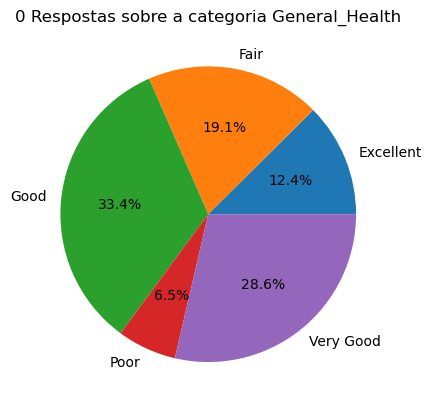

['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']
[45, 5, 143, 41, 1310]


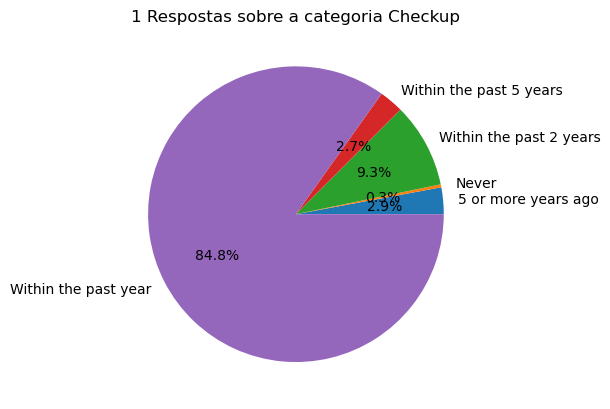

['No' 'Yes']
[598, 946]


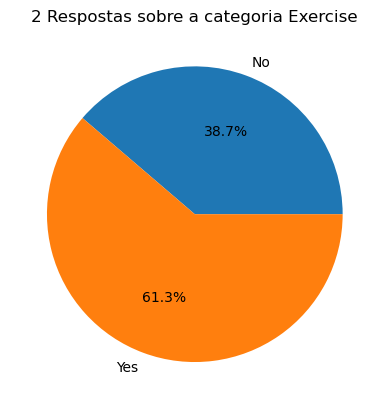

['No' 'Yes']
[1350, 194]


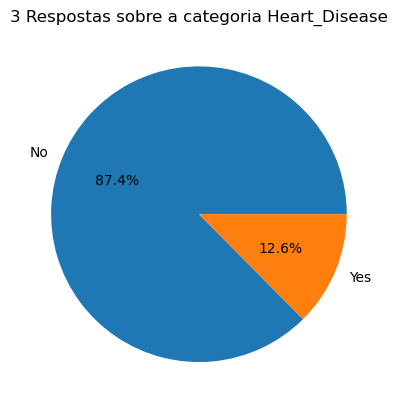

['No' 'Yes']
[1318, 226]


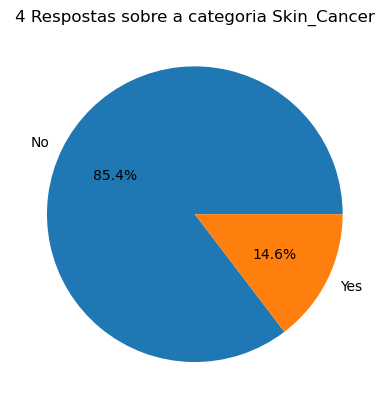

['No' 'Yes']
[1348, 196]


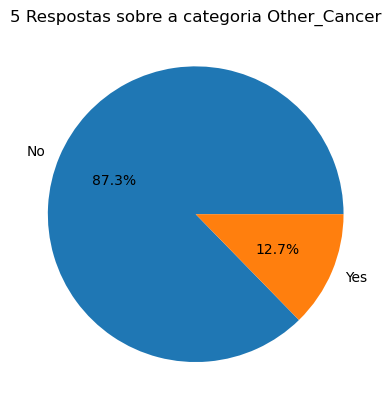

['No' 'Yes']
[1262, 282]


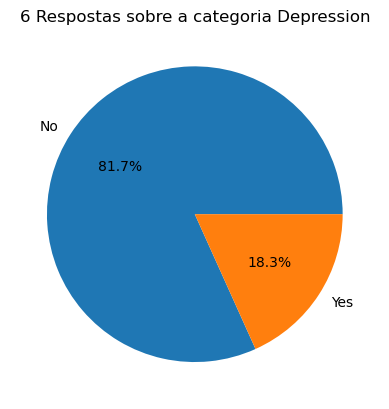

['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']
[1181, 25, 330, 8]


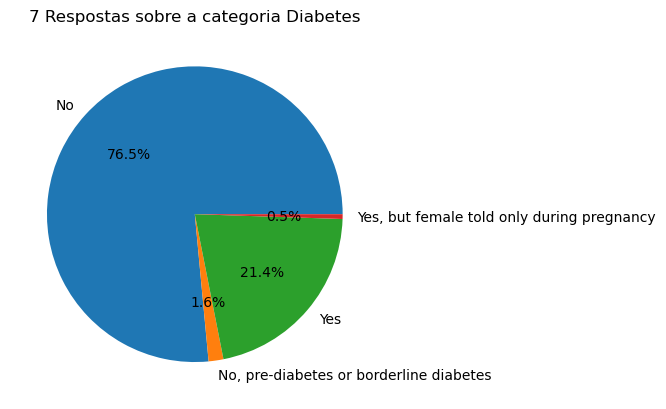

['No' 'Yes']
[812, 732]


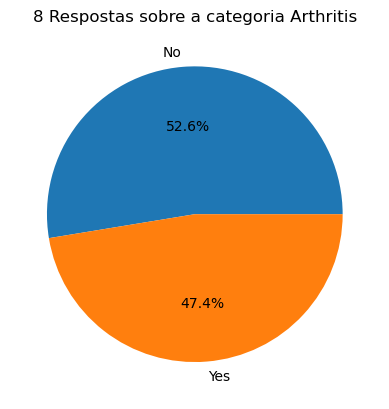

['Female' 'Male']
[992, 552]


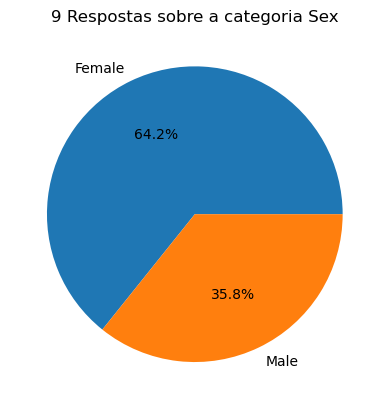

['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']
[44, 38, 63, 53, 76, 72, 81, 115, 190, 208, 248, 159, 197]


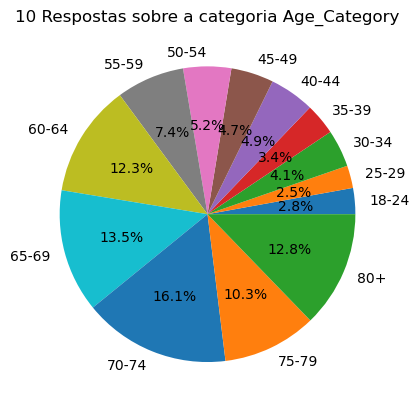

['135.0' '140.0' '142.0' '145.0' '147.0' '150.0' '152.0' '155.0' '157.0'
 '160.0' '163.0' '165.0' '168.0' '170.0' '173.0' '175.0' '178.0' '180.0'
 '183.0' '185.0' '188.0' '191.0' '193.0' '196.0' '198.0' '206.0']
[1, 1, 1, 2, 2, 17, 56, 55, 117, 124, 167, 136, 148, 114, 97, 104, 91, 81, 82, 57, 40, 25, 13, 7, 5, 1]


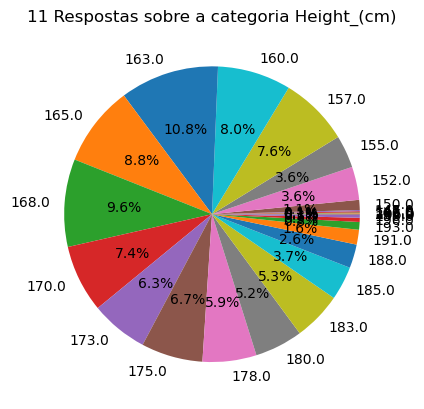

['101.15' '101.6' '102.06' '102.51' '102.97' '103.42' '103.87' '104.33'
 '105.23' '105.69' '106.14' '106.59' '107.05' '107.5' '107.95' '108.41'
 '108.86' '109.77' '110.22' '110.68' '111.13' '111.58' '112.04' '112.49'
 '113.4' '114.31' '114.76' '115.67' '116.12' '117.03' '117.48' '117.93'
 '118.39' '119.29' '119.75' '120.2' '120.66' '121.11' '121.56' '122.02'
 '122.47' '123.38' '124.28' '124.74' '125.19' '127.01' '129.27' '131.09'
 '131.54' '132.45' '132.9' '133.36' '133.81' '135.62' '136.08' '136.98'
 '138.35' '139.71' '142.88' '143.34' '145.15' '145.6' '147.42' '151.95'
 '154.22' '156.49' '158.76' '162.39' '167.83' '170.1' '172.37' '175.54'
 '176.9' '32.66' '33.11' '34.02' '40.82' '42.64' '43.09' '44.45' '44.91'
 '45.36' '45.81' '46.27' '46.72' '47.63' '48.53' '48.99' '49.44' '49.9'
 '50.8' '51.26' '51.71' '52.16' '52.62' '53.07' '53.52' '54.43' '54.88'
 '55.34' '55.79' '56.25' '56.7' '57.15' '57.61' '58.06' '58.51' '58.97'
 '59.87' '60.33' '60.78' '61.23' '61.69' '62.14' '62.6' '63.0

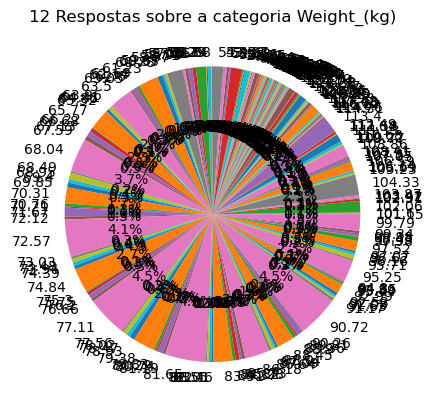

['14.06' '14.54' '15.82' '16.04' '16.23' '16.54' '16.62' '16.64' '16.73'
 '17.23' '17.38' '17.47' '17.54' '17.58' '17.75' '17.76' '17.79' '17.81'
 '17.91' '18.01' '18.02' '18.04' '18.07' '18.24' '18.27' '18.29' '18.31'
 '18.56' '18.69' '18.71' '18.72' '18.75' '18.79' '18.88' '18.89' '18.95'
 '19.13' '19.14' '19.2' '19.26' '19.27' '19.37' '19.47' '19.53' '19.57'
 '19.67' '19.74' '19.77' '19.8' '19.84' '19.87' '19.94' '19.97' '20.0'
 '20.05' '20.07' '20.08' '20.09' '20.12' '20.18' '20.2' '20.22' '20.25'
 '20.34' '20.36' '20.37' '20.38' '20.4' '20.48' '20.5' '20.51' '20.53'
 '20.6' '20.62' '20.63' '20.64' '20.78' '20.8' '20.82' '20.83' '20.85'
 '20.92' '20.98' '21.03' '21.09' '21.11' '21.13' '21.14' '21.18' '21.21'
 '21.22' '21.24' '21.26' '21.29' '21.4' '21.41' '21.46' '21.52' '21.58'
 '21.61' '21.63' '21.7' '21.79' '21.8' '21.81' '21.83' '21.86' '21.87'
 '21.89' '21.91' '21.93' '21.95' '21.97' '22.0' '22.04' '22.14' '22.15'
 '22.24' '22.26' '22.3' '22.31' '22.32' '22.36' '22.38' '22.4' 

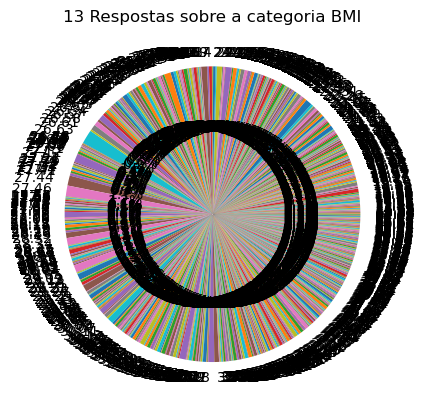

['No' 'Yes']
[920, 624]


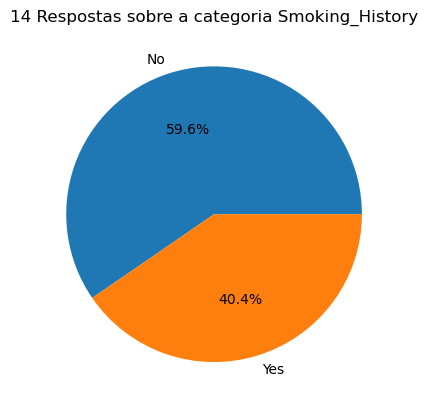

['0.0' '1.0' '10.0' '11.0' '12.0' '15.0' '16.0' '17.0' '2.0' '20.0' '24.0'
 '25.0' '28.0' '29.0' '3.0' '30.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0']
[1028, 85, 27, 1, 26, 17, 11, 1, 72, 26, 1, 6, 12, 1, 37, 46, 64, 24, 10, 8, 39, 2]


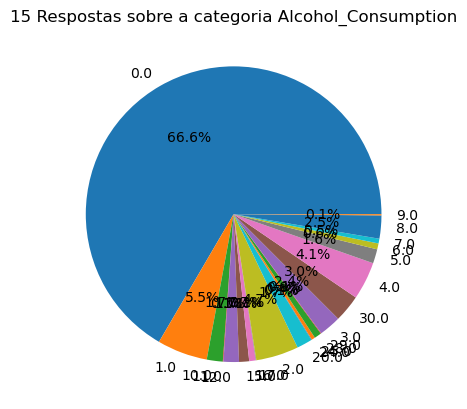

['0.0' '1.0' '10.0' '12.0' '120.0' '14.0' '15.0' '16.0' '2.0' '20.0'
 '24.0' '25.0' '28.0' '3.0' '30.0' '32.0' '4.0' '40.0' '5.0' '6.0' '60.0'
 '7.0' '8.0' '80.0' '90.0']
[45, 33, 23, 160, 7, 1, 15, 90, 60, 58, 11, 5, 21, 29, 506, 1, 78, 1, 23, 9, 147, 4, 150, 1, 66]


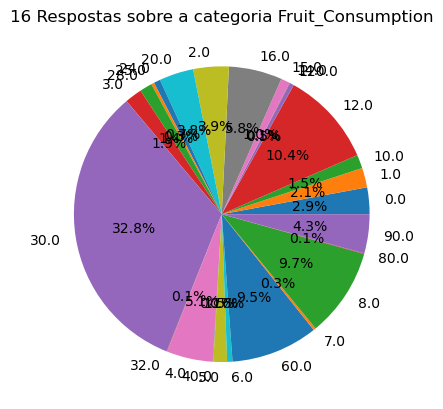

['0.0' '1.0' '10.0' '11.0' '12.0' '120.0' '13.0' '14.0' '15.0' '16.0'
 '17.0' '18.0' '19.0' '2.0' '20.0' '22.0' '24.0' '25.0' '27.0' '28.0'
 '3.0' '30.0' '4.0' '40.0' '5.0' '56.0' '6.0' '60.0' '7.0' '8.0' '80.0'
 '90.0']
[131, 55, 28, 1, 218, 2, 1, 1, 30, 105, 1, 1, 1, 82, 83, 1, 8, 6, 1, 14, 34, 178, 229, 3, 38, 1, 14, 23, 8, 240, 1, 5]


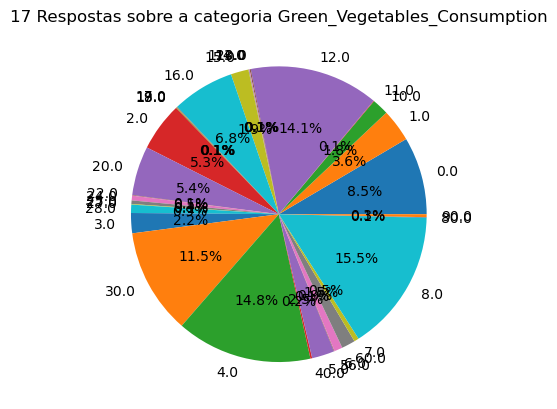

['0.0' '1.0' '10.0' '12.0' '120.0' '14.0' '15.0' '16.0' '2.0' '20.0'
 '21.0' '24.0' '25.0' '28.0' '3.0' '30.0' '32.0' '33.0' '4.0' '48.0' '5.0'
 '6.0' '60.0' '7.0' '8.0' '9.0' '90.0']
[276, 155, 31, 104, 1, 3, 24, 42, 168, 25, 1, 3, 1, 6, 68, 45, 1, 1, 331, 1, 32, 9, 7, 11, 195, 2, 1]


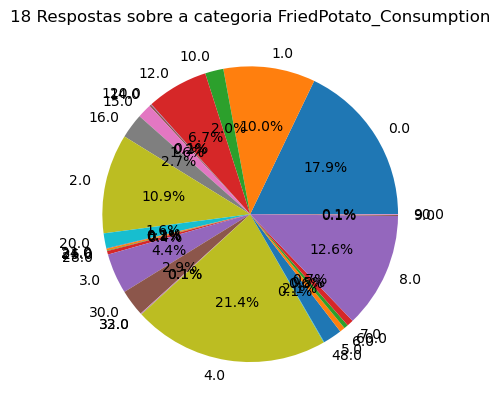

'\nfor i in datasetC:\n    print(len(i))\nprint(len(datasetC.T))\n'

In [36]:
import matplotlib.pyplot as plt

# 2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.

# exemplos do dataset
'''
for i in range(len(categorias)):
    print("Categoria "+str(categorias[i])+":")
    print(datasetC[i,0:5],end="\n\n")
'''

# tipos de diferentes respostas a cada categoria
for i in range(len(categorias)):
    print("Tipos de respostas para a categoria "+str(categorias[i])+":")
    print(np.unique(datasetC[i]),end="\n\n")



# graficos para respostas
count = 0
for i in datasetC:
	unicos = np.unique(i)
	valores = [np.count_nonzero(i==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(count)+" Respostas sobre a categoria "+str(categorias[count]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()
	count+=1 


# pessoas que dizem que n fazem exercicio -> +% na parte de doencas
'''
indices = []
for i in range(len(datasetC[2])):
    #3 4 5 6 7 8
    if datasetC[2][i] == "No":
        indices.append(i)

for i in range(3,9):
	unicos = np.unique(datasetC[i])
	valores = [str(datasetC[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que nao fazem exercicio para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''


# ver que respostas deram as pessoas que tem problemas cardiacos
'''
indices = []
for i in range(len(datasetC[3])):
    if datasetC[3][i] == "Yes":
        indices.append(i)

for i in range(len(categorias)):
	unicos = np.unique(datasetC[i])
	valores = [str(datasetC[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que têm doenças cardiacas para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''

# 2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.

# falar da inconsistencia das batatas fritas / alcool / fruta / vegetais
# vou usar quantas vezes por mes come/bete a categoria

# mostrar que nao tem valores em falta
'''
for i in datasetC:
    print(len(i))
print(len(datasetC.T))
'''

### 3. Data Preparation

- 3.1. Select data - Determine which data sets will be used and document reasons for inclusion/exclusion.
- 3.2. Clean data - Often this is the lengthiest task. Without it, you’ll likely fall victim to garbage-in, garbage-out. A common practice during this task is to correct, impute, or remove erroneous values.
- 3.3. Construct data - Derive new attributes that will be helpful. For example, derive someone’s body mass index from height and weight fields.
- 3.4. Integrate data - Create new data sets by combining data from multiple sources.
- 3.5. Format data - Re-format data as necessary. For example, you might convert string values that store numbers to numeric values so that you can perform mathematical operations.

Esta parte vai ser para a parte de alterar o dataset que o stor disse, depois temos de incluir estes topicos talvez

###### - Randomly remove 10% and 20% of the values of the features the dataset and explore two different strategies to handle missing values;
###### - Experiment with data normalization, data discretization, and data reduction. Apply these steps to the original, unchanged, dataset.

#### Strategies to handle missing values

Para poder testar vários métodos para lidar com "missing values", temos primeiro que gerar uma database com missing values, para simular isto, a função a baixo remove aleatoreamente uma percentagem de datapoints da dataset e substitui por None, ficando da seguinte forma:

| Health | Checkup           | Exer | HD | SC | OC | D | Di | A | Sex    | Age | cm | kg | BMI   | SH | AC | FC | GVC | FPC |
|-----------------|-------------------------|----------|---------------|-------------|--------------|------------|----------|-----------|--------|--------------|-------------|-------------|-------|-----------------|---------------------|-------------------|-----------------------------|-------------------------|
| Poor           | Within the past 2 years | No       | None          | No          | No           | No         | No       | Yes       | None   | 70-74        | None        | 32.66       | None  | Yes             | 0.0                 | 30.0             | None                       | 12.0                   |
| None           | Within the past year    | None     | Yes           | No          | None         | No         | Yes      | None      | Female | None         | 165.0       | None        | 28.29 | No              | 0.0                 | 30.0             | 0.0                        | None                   |
| Very Good      | Within the past year    | Yes      | None          | No          | None         | No         | None     | No        | Female | 60-64        | 163.0       | 88.45       | None  | No              | 4.0                 | None             | 3.0                        | None                   |
| Poor           | None                    | Yes      | Yes           | None        | No           | No         | Yes      | None      | Male   | 75-79        | None        | None        | 28.73 | No              | None                | 30.0             | 30.0                       | 8.0                    |


In [37]:
# remove os dados do dataset dado com a percentagem dada
def damage_dataset(percentagem,dataset):
	"""
	Substitui por None `percentagem`% dos data-points da dataset
	"""
    
	tamanho = 0
	for i in range(len(dataset)): # calcula tamanho do dataset
		tamanho += len(dataset[i])

	for i in range(int(tamanho*percentagem)):
		dataset[random.randint(0,len(dataset)-1)][random.randint(0,len(dataset[0])-1)] = None # elemento random mete para None

	return dataset

In [38]:
from collections import Counter						#---------------------------------#
from sklearn.preprocessing import LabelEncoder		#      Handle Missing Values      #
													#---------------------------------#

# Metodo extra - apagar os dados

copia = datasetC.copy()
testes = damage_dataset(0.2,copia) # dataset com None
ok = 0
for i in testes[0]:
	if i == "None":
		ok+=1
print("Nones testes[0] "+str(ok))
print("len() testes[0] "+str(len(testes[0])))


# METODO 1 - Vicente, substituir pelo valor mais frequente

# pega no dataset com Nones e substitui-os pelo valor mais frequente da categoria
def mais_freq(dataset):
	dataset = dataset.tolist() # é mais rapido se for lista normal em vez de np.array (nao sei porque)
	maxx = []
	for i in range(len(dataset)): # VER O BMI
		conta = Counter(dataset[i])
		del conta["None"]
		#print(conta.most_common(1))
		maxx.append(conta.most_common(1))

	#print(maxx)
	#print(maxx[0])
	#print(maxx[0][0][0])

	for i in range(len(dataset)):
		for j in range(len(dataset[i])):
			if dataset[i][j] == "None":
				dataset[i][j] = maxx[i][0][0]
	
	return dataset

testes2 = mais_freq(testes) # dataset com None substituido por mais frequente
ok2 = 0
for i in testes2[0]:
	if i == "None":
		ok2+=1
print("Nones testes2[0] "+str(ok2))
print("len() testes2[0] "+str(len(testes2[0])))


# METODO 2 - jonnas

Nones testes[0] 288
len() testes[0] 1544
Nones testes2[0] 0
len() testes2[0] 1544


In [39]:
datasetForTests = datasetC.copy() # copia, para deixar a original intacta
damagedDataset = damage_dataset(0.2,copia) # Substitui 20% dos datapoints por None

# Method 1 (Vicente)
maisFreqDataset = mais_freq(damagedDataset) # Substitui os missing values pelo valor mais frequente

# Method 2 (Jonnas)

#### Mudanças ao Dataset (Data reduction, Normalization, Discretization)

['150.0', '165.0', '163.0', '180.0', '191.0', '183.0', '175.0', '165.0', '163.0', '163.0', '160.0', '175.0', '168.0', '178.0', '152.0', '163.0', '183.0', '168.0', '178.0', '163.0']
[150.0, 165.0, 163.0, 180.0, 191.0, 183.0, 175.0, 165.0, 163.0, 163.0, 160.0, 175.0, 168.0, 178.0, 152.0, 163.0, 183.0, 168.0, 178.0, 163.0]
['150-160', '161-170', '161-170', '171-180', '191-200', '181-190', '171-180', '161-170', '161-170', '161-170', '150-160', '171-180', '161-170', '171-180', '150-160', '161-170', '181-190', '161-170', '171-180', '161-170', '150-160', '171-180', '171-180', '161-170', '150-160', '150-160', '150-160', '150-160', '191-200', '171-180', '150-160', '161-170', '181-190', '150-160', '181-190', '161-170', '161-170', '161-170', '161-170', '161-170', '150-160', '171-180', '161-170', '171-180', '161-170', '171-180', '161-170', '161-170', '161-170', '150-160']
1544
['150-160' '161-170' '171-180' '181-190' '191-200' '<150' '>200']
[369, 565, 373, 179, 50, 7, 1]


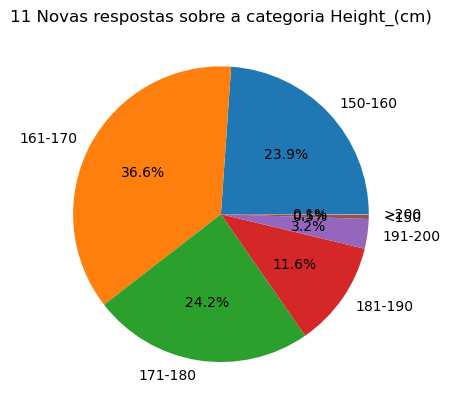

['101-120' '121-140' '40-60' '61-80' '81-100' '<40' '>140']
[206, 62, 173, 595, 482, 4, 22]


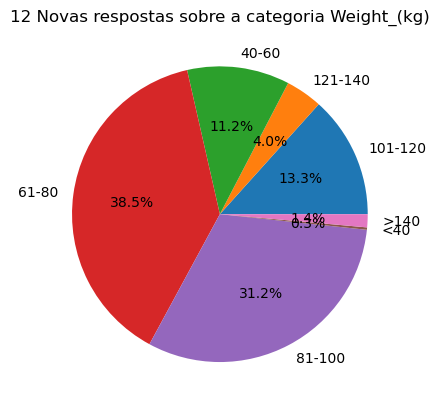

['gorda' 'magra' 'normal' 'obesa']
[126, 136, 1262, 20]


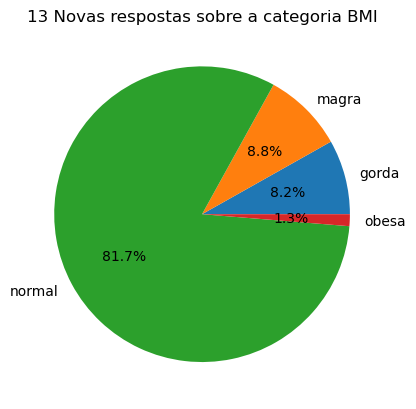

['bastante' 'medio' 'muito' 'nada' 'pouco']
[66, 137, 55, 1028, 258]


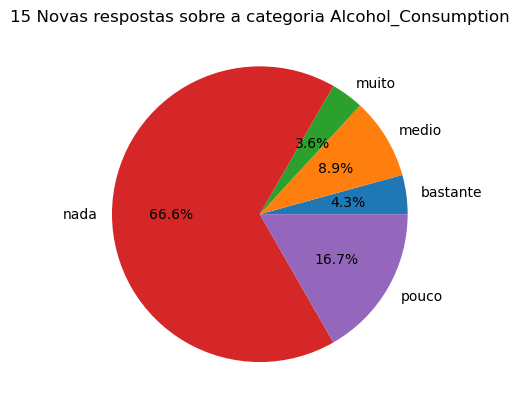

['bastante' 'medio' 'muito' 'muito pouco' 'nada' 'pouco']
[74, 601, 149, 386, 45, 289]


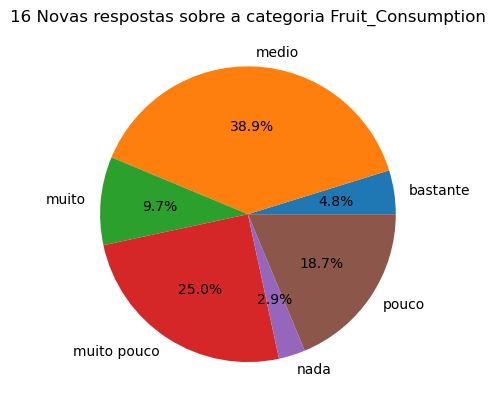

[' muito' 'medio' 'muito pouco' 'nada' 'pouco']
[35, 294, 700, 131, 384]


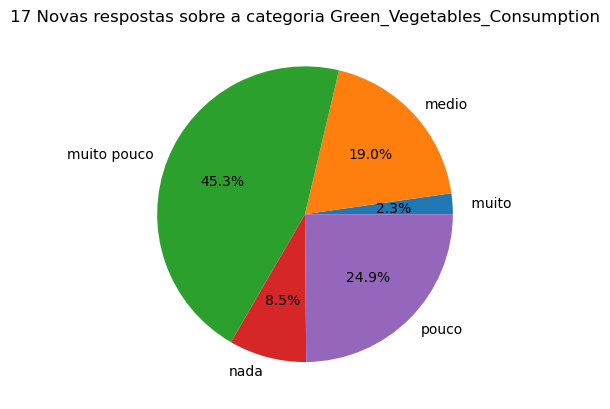

['bastante' 'medio' 'muito' 'nada' 'pouco']
[162, 247, 137, 276, 722]


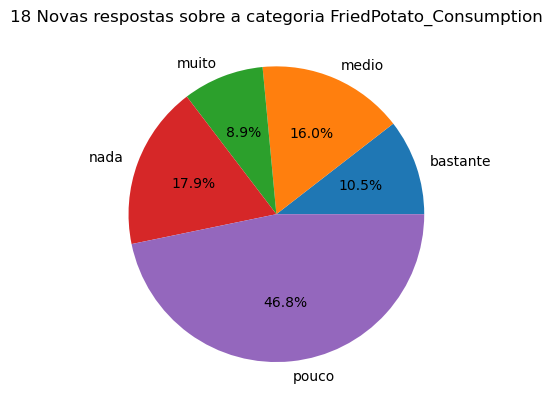

[array([3, 4, 4, ..., 3, 2, 2]), array([2, 4, 4, ..., 4, 4, 4]), array([0, 0, 1, ..., 0, 1, 1]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 2, 2, ..., 0, 0, 0]), array([1, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([10, 10,  8, ..., 10,  7,  7]), array([150., 165., 163., ..., 191., 175., 185.]), array([32.66, 77.11, 88.45, ..., 81.65, 77.11, 88.45]), array([14.54, 28.29, 33.47, ..., 22.5 , 25.1 , 25.73]), array([1, 0, 0, ..., 1, 1, 0]), array([0., 0., 4., ..., 0., 3., 2.]), array([30., 30., 12., ...,  4., 90., 12.]), array([16.,  0.,  3., ...,  2., 30.,  4.]), array([12.,  4., 16., ...,  2.,  8., 12.])]
19


In [40]:

# DATA DISCRETIZATION - Vicente

# as comidas e bebidas para - nada muito_pouco pouco medio muito bastante
# altura - >100, 100-110, 111-120, 121-130, 131-140, 141-150, 151-160, 161-170, 171-180, 181-190, 191-200, <200
# BMI -> muito magro, magro normal, gordo, obeso, obesidade morbida
# peso -> data['bins'] = pd.cut(data['values'], bins=5, labels=['Low', 'Medium', 'High'])

def data_discretization(dataset):
	"""
	Discretiza atributos numéricos do dataset em intervalos categóricos.

	Esta função processa colunas específicas do dataset para substituir valores numéricos 
	por rótulos categóricos com base em limites definidos. Por exemplo:
	- Altura é agrupada em intervalos como "<150", "150-160", etc.
	- Peso é agrupado em intervalos como "<40", "40-60", etc.
	- IMC é categorizado em "magra", "normal", "gorda" ou "obesa".
	- Consumo de álcool, frutas, vegetais e batata frita é categorizado em níveis 
	descritivos como "nada", "pouco", "medio", "muito" ou "bastante".

	O dataset processado é retornado com os valores numéricos substituídos por rótulos 
	categóricos, tornando-o mais adequado para análises baseadas em categorias.
	"""

	print(dataset[11][0:20])
	for i in [11,12,13,15,16,17,18]:
		dataset[i] = list(map(float, dataset[i]))
	print(dataset[11][0:20])

	#ALTURA
	for i in range(len(dataset[11])):
		if dataset[11][i] < 150: # +1.5m
			dataset[11][i] = "<150"
		elif dataset[11][i] >= 150 and dataset[11][i] <=160: # entre 1.5 e 1.6 m
			dataset[11][i] = "150-160"
		elif dataset[11][i] > 160 and dataset[11][i] <=170: # entre 1.6 e 1.7 m
			dataset[11][i] = "161-170"
		elif dataset[11][i] > 170 and dataset[11][i] <=180: # entre 1.7 e 1.8 m
			dataset[11][i] = "171-180"
		elif dataset[11][i] > 180 and dataset[11][i] <=190: # entre 1.8 e 1.9 m
			dataset[11][i] = "181-190"
		elif dataset[11][i] > 190 and dataset[11][i] <=200: # entre 1.9 e 2.0 m
			dataset[11][i] = "191-200"
		else: # +2.0m
			dataset[11][i] = ">200"
	
	#PESO
	for i in range(len(dataset[12])):
		if dataset[12][i] < 40: # -40kg
			dataset[12][i] = "<40"
		elif dataset[12][i] >= 40 and dataset[12][i] <=60: # entre 40 a 60 kg
			dataset[12][i] = "40-60"
		elif dataset[12][i] > 60 and dataset[12][i] <=80: # entre 60 a 80 kg
			dataset[12][i] = "61-80"
		elif dataset[12][i] > 80 and dataset[12][i] <=100: # entre 80 a 100 kg
			dataset[12][i] = "81-100"
		elif dataset[12][i] > 100 and dataset[12][i] <=120: # entre 100 a 120 kg
			dataset[12][i] = "101-120"
		elif dataset[12][i] > 120 and dataset[12][i] <=140: # entre 120 a 140 kg
			dataset[12][i] = "121-140"
		else: # +140kg
			dataset[12][i] = ">140" 

	#BMI
	for i in range(len(dataset[13])):
		bmi = 10 + (dataset[13][i] / 100) * (50-10) # meter a percentagem do dataset em categorias tabeladas do BMI
		if bmi < 18.5:
			dataset[13][i] = "magra"
		elif bmi >= 18.5 and bmi <= 24.9:
			dataset[13][i] = "normal"
		elif bmi >= 25 and bmi <= 29.9:
			dataset[13][i] = "gorda"
		else:
			dataset[13][i] = "obesa"
		
	#ALCOOL
	for i in range(len(dataset[15])):
		if dataset[15][i] == 0: # 0 - nada
			dataset[15][i] = "nada"
		elif dataset[15][i]>0 and dataset[15][i] <= 4: # 1x por semana - pouco
			dataset[15][i] = "pouco"
		elif dataset[15][i]>4 and dataset[15][i] <=12: #2/3x por semana - medio
			dataset[15][i] = "medio"
		elif dataset[15][i] > 12 and dataset[15][i] <= 20: # 4/5x por semana - muito
			dataset[15][i] = "muito"
		else: # +5x por semana - bastante
			dataset[15][i] = "bastante"

	#FRUTA
	for i in range(len(dataset[16])):
		if dataset[16][i] == 0: # 0 - nada
			dataset[16][i] = "nada"
		elif dataset[16][i] >0 and dataset[16][i] <9: # 1/2x por semana - muito pouco
			dataset[16][i] = "muito pouco"
		elif dataset[16][i] >=9 and dataset[16][i] <17: # 3/4x por semana - pouco
			dataset[16][i] = "pouco"
		elif dataset[16][i] >=17 and dataset[16][i] <31: # 5x por semana a 1x por dia - medio
			dataset[16][i] = "medio"
		elif dataset[16][i] >=31 and dataset[16][i] <61: # 1/2x por dia - muito
			dataset[16][i] = "muito"
		else: # +2x por dia - bastante
			dataset[16][i] = "bastante"

	#VEGETAIS
	for i in range(len(dataset[17])):
		if dataset[17][i] == 0: # 0 nada
			dataset[17][i] = "nada"
		elif dataset[17][i] >0 and dataset[17][i] <9: # 1/2x por semana - muito pouco
			dataset[17][i] ="muito pouco"
		elif dataset[17][i] >=9 and dataset[17][i] <17: # 3/4x por semana - pouco
			dataset[17][i] = "pouco"
		elif dataset[17][i] >=17 and dataset[17][i] <31: # 5x por semana a 1x por dia - medio
			dataset[17][i] = "medio"
		else: # +1x por dia - muito
			dataset[17][i] = " muito"

	#BATATA FRITA
	for i in range(len(dataset[18])):
		if dataset[18][i] == 0: # 0 - nada
			dataset[18][i] = "nada"
		elif dataset[18][i]> 0 and dataset[18][i] <5: #1x por semana - pouco
			dataset[18][i] = "pouco"
		elif dataset[18][i] >=5 and dataset[18][i] <9: # 2x por semana - medio
			dataset[18][i] = "medio"
		elif dataset[18][i] >=9 and dataset[18][i] <13: # 3x por semana - muito
			dataset[18][i] = "muito"
		else: # +3x por semana - bastante
			dataset[18][i] = "bastante"

	return dataset

copia2 = datasetC.copy()
copia2 = copia2.tolist()

#testes3 = data_discretization(testes2) # dataset com Nones, substituidos por mais frequente, com data discretization

testes4 = data_discretization(copia2) # dataset com data discretization
#''' graficos
print(testes4[11][0:50])
print(len(testes4[11]))

testes4 = np.array(testes4)

for i in [11,12,13,15,16,17,18]:
	unicos = np.unique(testes4[i])
	valores = [np.count_nonzero(testes4[i]==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(i)+" Novas respostas sobre a categoria "+str(categorias[i]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()



# DATA REDUCTION - Vicente

#print(dataset_num) dups
#print(len(dataset_num))
#print(len(np.unique(dataset_num,axis=0)))

# fazer modelos pra ver atributos que posso remover (0, 1 e 6 principalmente)






# meter os dados para numeros

testes4 = np.array(testes4)
dataset_num = []

# meter o datset para numeros para dar com os modelos
for col in datasetC:
    try:
        dataset_num.append(col.astype(float))
    except ValueError:
        le = LabelEncoder()
        encoded_col = le.fit_transform(col)
        dataset_num.append(encoded_col)

print(dataset_num)
print(len(dataset_num))
dataset_num = np.array(dataset_num).T # dataset com as repostas normais como está no csv

In [41]:
def normalise_dataset(dataset):
    # todo
    return dataset

In [43]:
datasetForTests = datasetC.copy() # copia, para deixar a original intacta

# Data reduction (Vicente)

# Discretization (Vicente)
specialSnowFlakeDataset = datasetForTests.tolist() # 🤡 Isto não pode estar na função em baixo?
discretizedDataset = data_discretization(specialSnowFlakeDataset) # Aplica discretização aos dados para categorizá-los

# Normalization (Jonnas)
NormalisedDataset = normalise_dataset(datasetForTests) # normalisa os valores

['150.0', '165.0', '163.0', '180.0', '191.0', '183.0', '175.0', '165.0', '163.0', '163.0', '160.0', '175.0', '168.0', '178.0', '152.0', '163.0', '183.0', '168.0', '178.0', '163.0']
[150.0, 165.0, 163.0, 180.0, 191.0, 183.0, 175.0, 165.0, 163.0, 163.0, 160.0, 175.0, 168.0, 178.0, 152.0, 163.0, 183.0, 168.0, 178.0, 163.0]


### 4. Modeling

- 4.1. Select modeling techniques - os algoritmos que o stor pede no enunciado
- 4.2. Generate test design - dependendo do modelo ter diferentes valores de sets de train, teste e validation
- 4.3. Build model - implementar os modelos
- 4.4. Assess model - interpretar os resultados dos modelos e comprara-los e testalos entre eles para ver qual/quais são os melhores

### Supervised Learning

In [45]:
def decision_trees(dataset):
    # todo
    return dataset

def multi_layer_perceptron(dataset):
    # todo
    return dataset

def k_nn(dataset):
    # todo
    return dataset

In [46]:
datasetForTests = datasetC.copy() # copia, para deixar a original intacta

# olha para a Ficha 4, para como fizeste a função plot_performance(str_sizes, num_trials, performance_func), para saber o que retornar.

decision_trees(datasetForTests)

multi_layer_perceptron(datasetForTests)

k_nn(datasetForTests)

array([['Poor', 'Very Good', 'Very Good', ..., 'Poor', 'Good', 'Good'],
       ['Within the past 2 years', 'Within the past year',
        'Within the past year', ..., 'Within the past year',
        'Within the past year', 'Within the past year'],
       ['No', 'No', 'Yes', ..., 'No', 'Yes', 'Yes'],
       ...,
       ['30.0', '30.0', '12.0', ..., '4.0', '90.0', '12.0'],
       ['16.0', '0.0', '3.0', ..., '2.0', '30.0', '4.0'],
       ['12.0', '4.0', '16.0', ..., '2.0', '8.0', '12.0']], dtype='<U42')

#### Unsupervised Learning

categorias ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
[[ 3.  2.  0. ... 30. 16. 12.]
 [ 4.  4.  0. ... 30.  0.  4.]
 [ 4.  4.  1. ... 12.  3. 16.]
 ...
 [ 3.  4.  0. ...  4.  2.  2.]
 [ 2.  4.  1. ... 90. 30.  8.]
 [ 2.  4.  1. ... 12.  4. 12.]]
1544
1544
1544


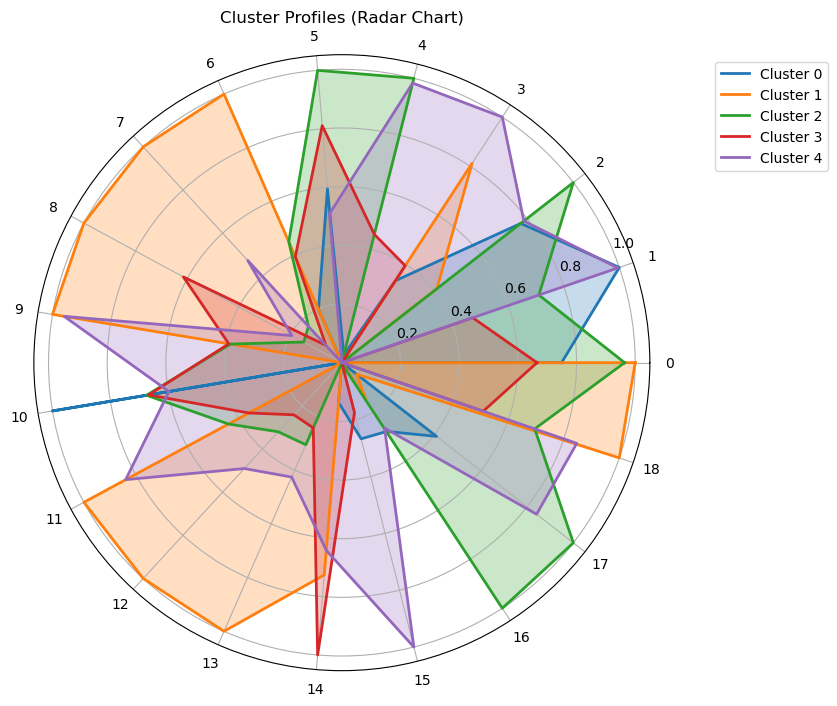

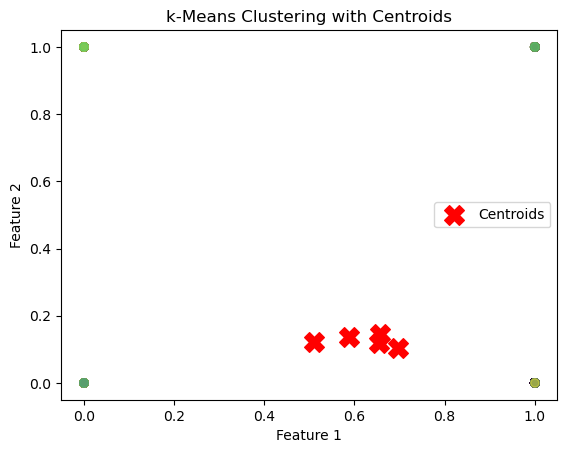

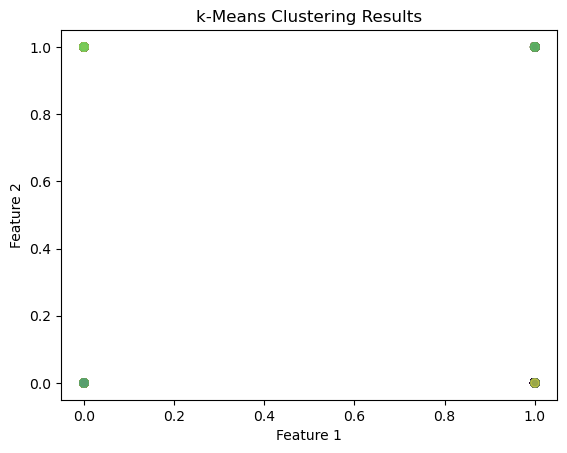

/tmp/ipykernel_70822/2838720063.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=data_with_clusters, palette='viridis')


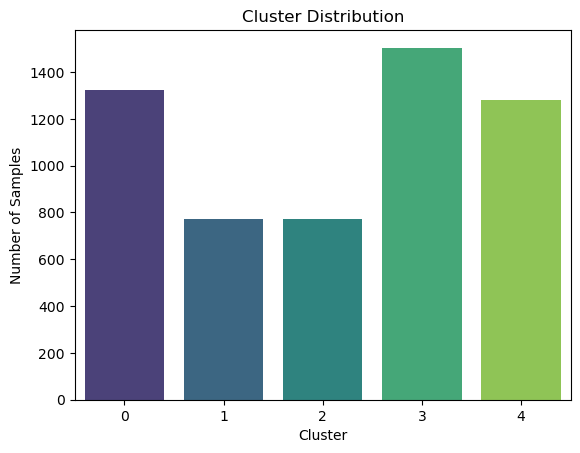

[0 1]
Counter({0: 1350, 1: 194})


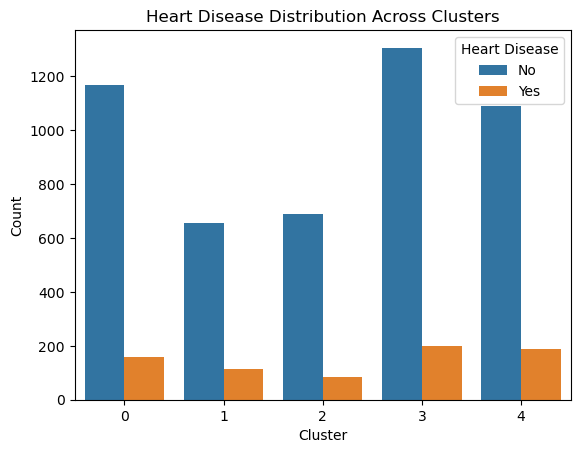

In [47]:
										#-----------------------------#
										#         4. Modeling         #
										#-----------------------------#

# UNSUPERVISED LEARNING - Vicente

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns


print("categorias "+str(categorias))


print(dataset_num)
print(len(dataset_num))
print(len(np.unique(dataset_num,axis=0)))

#unicos = np.unique(dataset_num)
#valores = [np.count_nonzero(dataset_num==x) for x in unicos]
#print(unicos)
#print(valores)


kmeans = KMeans(n_clusters=5)
kmeans.fit(dataset_num)
cluster_labels = kmeans.labels_

print(len(cluster_labels))

# Step 3: Analyze clusters
# Add cluster labels to a DataFrame for analysis
data_with_clusters = pd.DataFrame(dataset_num)
data_with_clusters['Cluster'] = cluster_labels

#print(dataset_num)
#print(data_with_clusters)

# Display basic cluster statistics
#cluster_summary = data_with_clusters.groupby('Cluster').mean()
#print("Cluster Summary:")
#print(cluster_summary)

# Step 4: Visualize results
# Plot first two features for visualization (or use PCA for dimensionality reduction)



from math import pi

# Compute mean values for each feature in each cluster
cluster_profiles = data_with_clusters.groupby('Cluster').mean()

# Radar chart requires normalizing the data
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Create radar chart
categories = cluster_profiles_normalized.columns
num_clusters = cluster_profiles_normalized.shape[0]
angles = np.linspace(0, 2 * pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
for i in range(num_clusters):
    values = cluster_profiles_normalized.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Cluster Profiles (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


# Extract cluster centroids
centroids = kmeans.cluster_centers_

# Scatter plot with centroids
plt.scatter(dataset_num[:, 2], dataset_num[:, 3], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
plt.title("k-Means Clustering with Centroids")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


plt.scatter(dataset_num[:, 2], dataset_num[:, 3], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title("k-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


sns.countplot(x='Cluster', data=data_with_clusters, palette='viridis')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.show()


#print(data_with_clusters['Cluster'])


# Assuming 'Heart_Disease' is the third column (index 2) in datasetC.T
heart_disease_column = testes4.T[:, 3]  # Extract the column
# Convert 'Yes' to 1 and 'No' to 0
heart_disease_column_numeric = np.where(heart_disease_column == 'Yes', 1, 0)
#print(len(data_with_clusters.T))  # Should match len(datasetC.T)
#print(len(heart_disease_column_numeric))  # Should match len(datasetC.T)
# Add heart disease column to the DataFrame with clusters
data_with_clusters['Heart Disease'] = heart_disease_column_numeric

print(np.unique(data_with_clusters['Heart Disease']))

print(Counter(data_with_clusters['Heart Disease']))
#print(len(data_with_clusters))  # Should match len(datasetC.T)
#print(data_with_clusters[0])
#print(len(heart_disease_column_numeric))  # Should match len(datasetC.T)


# Create a count plot to show heart disease distribution across clusters
sns.countplot(x='Cluster', hue='Heart Disease', data=data_with_clusters)
plt.title("Heart Disease Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Heart Disease", labels=["No", "Yes"])
plt.show()



### 5. Evaluation

- 5.1. Evaluate results - ver que modelos devemos usar e quais melhor correspondem com o business criteria
- 5.2. Review process - fazer uma revisão critica ao trabalho feito
- 5.3. Determine next steps - determnar se esta bom para o deploymente, se é preciso melhorar um pouco mais ou expandir o projeto // ns bem como fazer isto neste trabalho

In [31]:
										#-----------------------------#
										#        5. Evaluation        #
										#-----------------------------#

